# Mask tests for natural streams
Edge erosion test.

#### reclassify sky view non ditch amp

In [2]:
import numpy as np
import dask.array as da
from dask_image.ndfilters import generic_filter as d_gf
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize  # For downsampling
from numba import jit, njit
from numba import prange

Zone 12: Shape of original SVF: (5000, 5000)
Zone 12: Shape of processed SVF: (5000, 5000)


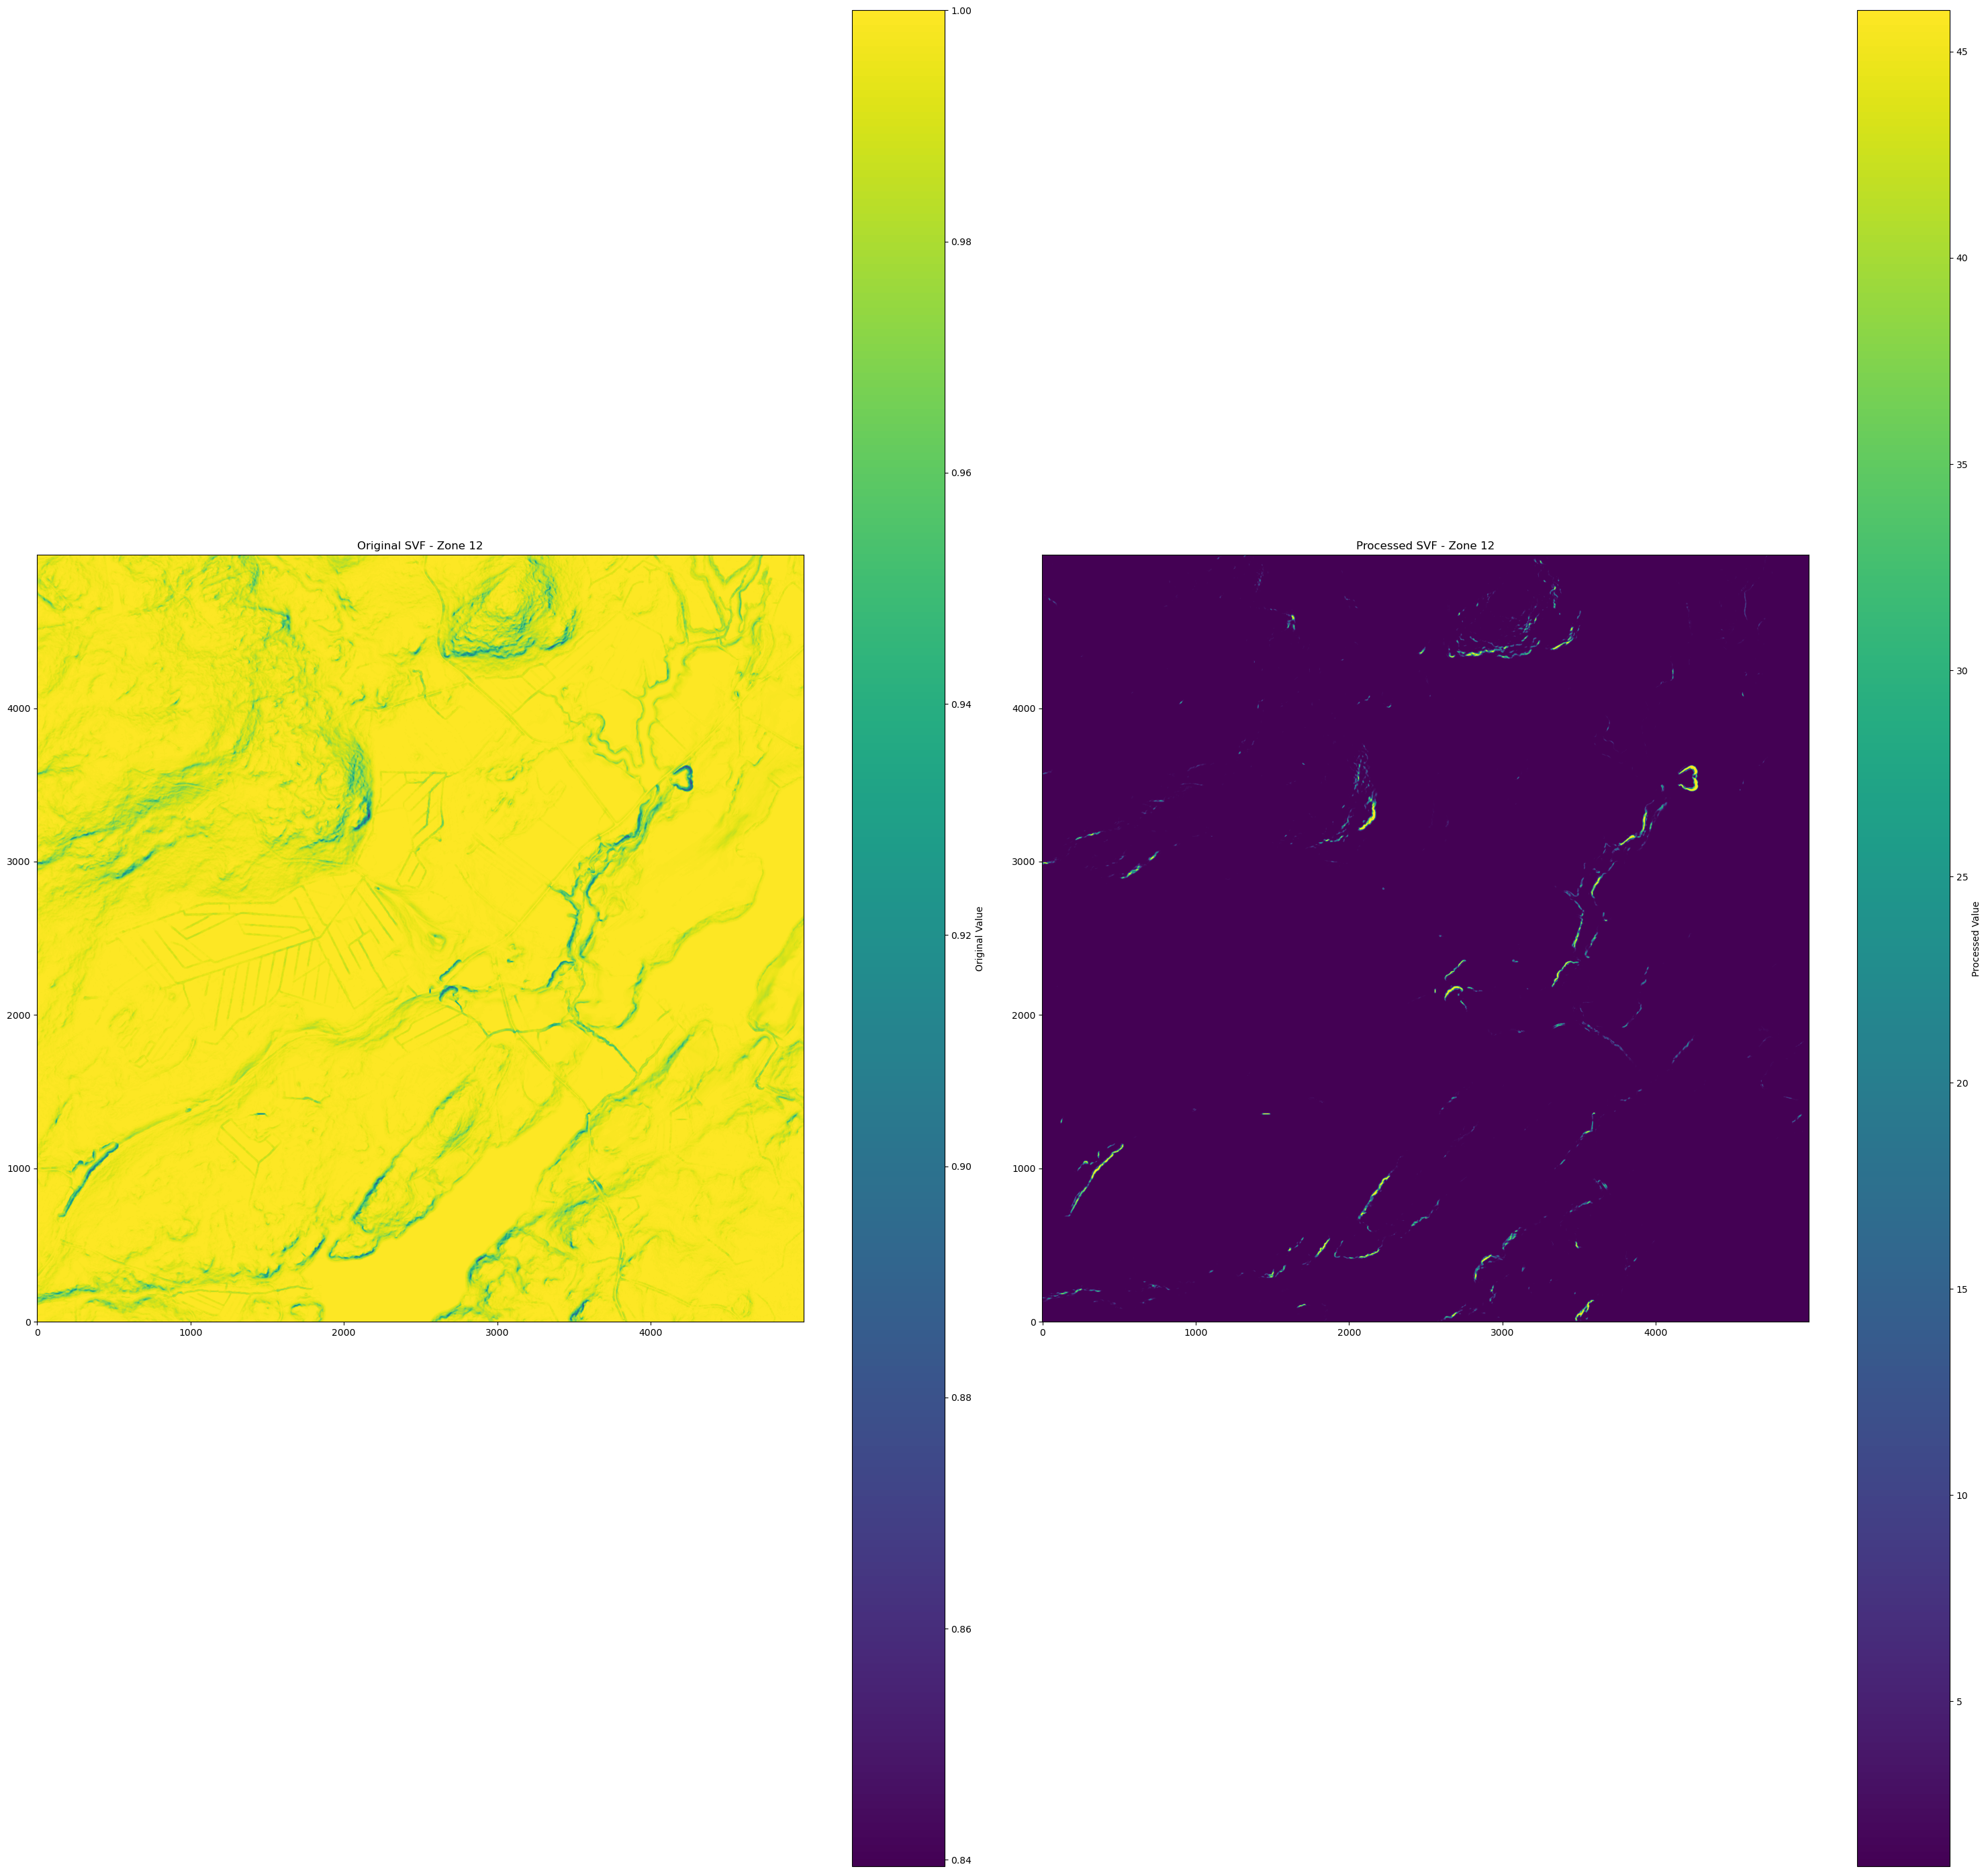

In [ ]:
import numpy as np
import dask.array as da
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

features_path = "../../01_Data/01_Raw/features/features"

# JIT-compiled function for reclassification
@jit(nopython=True)
def _reclassify_sky_view_non_ditch_amp(arr):
    """
    Internal non-ditch amplification reclassification for SkyViewFactor.
    Reclassifies based on the value thresholds.
    """
    new_arr = np.copy(arr)
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if arr[i, j] < 0.92:
                new_arr[i, j] = 46
            elif arr[i, j] < 0.94:
                new_arr[i, j] = 37
            elif arr[i, j] < 0.945:
                new_arr[i, j] = 29
            elif arr[i, j] < 0.955:
                new_arr[i, j] = 22
            elif arr[i, j] < 0.96:
                new_arr[i, j] = 16
            elif arr[i, j] < 0.965:
                new_arr[i, j] = 11
            elif arr[i, j] < 0.975:
                new_arr[i, j] = 7
            elif arr[i, j] < 0.985:
                new_arr[i, j] = 4
            elif arr[i, j] < 0.995:
                new_arr[i, j] = 2
            else:
                new_arr[i, j] = 1
    return new_arr


def svf_non_ditch_amp_create(zone_numbers=range(12, 13)):
    """
    Loads raw SVF data, processes it using reclassification,
    and creates a DataFrame summarizing the results.
    """
    data_frame = pd.DataFrame(columns=["zone_number", "original_shape", "processed_shape"])

    for zone_number in zone_numbers:
        # Load the SVF data
        svf = np.load(f"{features_path}/SVF_{zone_number}.npy")
        print(f"Zone {zone_number}: Shape of original SVF: {svf.shape}")

        # Convert to Dask array for parallel processing
        svf_dask = da.from_array(svf, chunks=(800, 800))

        # Resize the image before processing (this can be done using Dask as well)
        svf_resized = resize(svf_dask, (1501, 1677), mode='reflect', anti_aliasing=True)

        # Apply the reclassification on the Dask array
        svf_processed = da.map_blocks(_reclassify_sky_view_non_ditch_amp, svf_dask)

        # Compute the result
        svf_processed_computed = svf_processed.compute(scheduler="processes")
        print(f"Zone {zone_number}: Shape of processed SVF: {svf_processed_computed.shape}")

        # Update the DataFrame with the shapes
        data_frame = pd.concat([data_frame, pd.DataFrame([{
            "zone_number": zone_number,
            "original_shape": svf.shape,
            "processed_shape": svf_processed_computed.shape
        }])], ignore_index=True)

        # Visualize the original and processed data
        plt.figure(figsize=(30, 28))
        plt.subplot(1, 2, 1)
        plt.imshow(svf, cmap="viridis", origin="lower")
        plt.title(f"Original SVF non ditch amp - Zone {zone_number}")
        plt.colorbar(label="Original Value")

        plt.subplot(1, 2, 2)
        plt.imshow(svf_processed_computed, cmap="viridis", origin="lower")
        plt.title(f"Processed SVF non ditch amp - Zone {zone_number}")
        plt.colorbar(label="Processed Value")
        plt.tight_layout()
        plt.show()

    return data_frame


# Call the function to process the zones and get the DataFrame
data_frame = svf_non_ditch_amp_create()
